# Lab 6: System ID
### EECS 16B: Designing Information Devices and Systems II, Spring 2023

Updated by Steven Lu, Kaitlyn Chan (2021)

Updated by Steven Lu (2022)

Updated by Mingyang Wang, Shrey Aeron, and Megan Zeng (2022)

Updated by Jessica Fan (2023)

## <span style="color:navy">Table Of Contents</span>
-----

* [Introduction](#intro)
* [Part 1: Sensor Verification](#part1)
* [Part 2: Changing to Battery Power](#part2)
* [Part 3: Open Loop Data Collection and Parameter Estimation](#part3)
* [Part 4: Determining the Operating Point](#part4)

<a id='intro'></a>
## <span style="color:navy">Introduction</span>
-----

We have now completed the drive and microphone circuits for S1XT33N! Now, you will get S1XT33N to drive in a straight line. Before we can do that, however, we need information on the motors' physical characteristics as they drive on the ground: how sensitive they are to input changes, friction, noise, etc. This information can help determine which input PWM values to the motors result in straight motion.

There are two major types of error in sensing the car's trajectory: (1) noise in the sensor signals and (2) mechanical differences between the two sides of the car.

In this lab, we will check for the first type of noise and collect data to derive a linear model for the system. Note that this isn't perfect; in reality, the forces in the system are nonlinear. However, for simplicity, we approximate the system with a linear model. In the next two labs, we will use the data collected in this lab to control the S1XT33N's movement.

## Lab Note
* [Lab Note](https://eecs16b.org/lab/notes/lab_note6.pdf)

Review the lab note. The lab note provides a technical review of the concepts covered in lab as well as theoretical connections.

## Pre-Lab

Complete the pre-lab assignment before doing the lab. Submit your answers to the Gradescope assignment "</span>[\[Lab\] Pre-Lab 6: System ID](https://www.gradescope.com/courses/484565/assignments/2739316)." Please make sure that you submit to the correct assignment. Pre-Lab 6 is due on **Sunday, March 19 at 11:59pm**. No late submissions will be accepted.

## Help Request Form
Use this [form](https://eecs16b.org/lab-help) to request help in your debugging / conceptual needs.

<a id='part1'></a>

## <span style="color:navy">Part 1: Sensor Verification</span>
-----

Before we begin, let's make sure your encoders are still working from Lab 3.
### <span style="color:navy">Encoder Verification</span>
As a recap, here is the suggested breadboard layout for your reference

<img width="700px" src="images/correct_layout.jpg">


### Materials:
- Arduino + USB cable
- Car
- Power supply

### Steps (recap from Lab 3)
1. Connect the Arduino to the computer.
2. Power your motors with 9V from the +25V channel on the power supply (connect it to the switch like from Lab 3). **Set the current limit to 0.4 A**. 
3. Power your regulator input (the "Regulator 9V Rail" serving as an input to the 5V rail regulator) with the same +25V channel on the power supply as well. Do not power the 5V rail _directly_ from the PSU.
4. Pick up your car, then upload **`encoder_test_0_ticks.ino`** to the Arduino.
5. Open the serial monitor.
6. **Set the baud rate to `38400`**.
7. Follow the instructions on the serial monitor.
    - **Your car wheels are going to move. Make sure that you are still holding the car above the table/ground.**
    - The test will conduct 4 phases: both wheels at rest, only left wheel driving, only right wheel driving, and both wheels driving.
    - If your encoders are functioning properly, the serial monitor should print "Failure if encoder wheels are off. Success if encoder wheels are on." after each phase.

<img width="400px" src="images/proj-car-encoder2.jpg">

<a id='part2'></a>

## <span style="color:navy">Part 2: Changing to Battery Power</span>
-----

### Materials
- Two 9V batteries + battery leads

***In general, if you are testing things at your lab station (e.g. testing), use the power supply for 9V.*** Only use the 9V batteries if away from lab benches. Frequently using the batteries will drain them very quickly (~<1 hr). If the voltage of the batteries drops below 7.8V, they will no longer power your car consistently.
    
#### Notes
- You may want to velcro or tape down your batteries symmetrically to the back/front of your car. This will balance the weight distribution and help with controls in the next lab.
- We recommend removing your battery leads when not using the batteries to prevent shorts or energy drain.


### Procedure to change to battery power:
1. Disconnect the power supply's 9V source from the breadboard.
  - **Never leave both the 9V from the power supply and the battery connected at the same time.**
2. **Disconnect your regulator 9V rail from the motor 9V rail if you've connected them**. We will be using 2 separate batteries, one for the regulators + Arduino and one for the motors.
3. Knot your battery leads as shown in the image below so that the leads are separated.
    - This will drastically decrease the chance of the battery shorting and going kaboom.  <img width="15px" src="images/pandanuke.gif">

<img width="200px" src="images/proj-batt-lead.jpg">

4. Connect one battery to the switch (for motors) and the other to the voltage regulator. Ensure that the motor switch is in the OFF position. Connect the "Regulator 9V Rail" to `Vin` on the Arduino to power the Arduino.
   - When using the batteries, the red is 9V and black is ground.
   - The grounds of the 9V battery leads should go to the ground rails of the breadboard.

5. Use your oscilloscope or multimeter again to check that the output of your regulator is as expected and nothing was shorted. Ensure that the Arduino is being powered by checking that one of the built-in LEDs is on.

### Configuration Overview:

At any point, your car should be powered with one of the following three configurations:

1. **Stationary Configuration**: When testing at the lab station: 

<img width="600px" src="images/PowerDiagram_1.png">

The Arduino is powered through the USB while the motors and front end circuit are powered through the power supply

2. **Mobile Configuration**: When running the car on the ground: 

<img width="600px" src="images/PowerDiagram_2.png">

One battery powers the Arduino through $V_{in}$ and the front end circuit (through the 5V regulator). The other battery powers the motors.

3. **Transitory Configuration**: When downloading data from the Arduino to the computer after runs on the ground:

<img width="600px" src="images/PowerDiagram_3.png">

Similar to the mobile configuration, but the Arduino is connected to both 9V at $V_{in}$ and the computer via USB. This configuration is only necessary when we need to download data to the computer after a run; otherwise, disconnecting the power to $V_{in}$ is fine. **It is safe to power the Arduino through both $V_{in}$ and the USB at the same time.**

<a id='part3'></a>
## <span style="color:navy">Part 3: Open Loop Data Collection and Parameter Estimation</span>
-----

Now that we have verified our encoders' functionality, we will collect the data by uploading the sketch **`dynamics_data.ino`**. Glance through the sketch - it records the position of each wheel while varying the input signal $u[i]$ linearly from HIGH_PWM to LOW_PWM and back up. THis will be stored in the Arduino's local memory which can be retrieved by the serial monitor.

Note that the sampling period is $T_s = 500\mathrm{ms}$. A long sampling period is used to minimize error due to discretization of encoder ticks data.

**Important: For this first test, make sure that you are using the first set of 5 parameters in code block `SID1`** (abbreviated from System ID 1). These parameters will sweep through a range of PWM values, from 250 to 50 and back to 250 (the maximimum value a PWM can have is 255 and minimum is 0), while collecting 2 samples per PWM. The car will start fast, slow down, and speed back up during the test (it's possible that the car may stop in the middle before driving again if a PWM of 50 is not enough to overcome static friction).

### 3.1. About Data Collection

- Remember that the Arduino needs power from 9V at $Vin$ if not connected via USB cable to the computer. **It is safe to connect both at the same time.** 
- Upon receiving power, the Arduino will immediately begin running the last uploaded program. To prevent the car from unintentionally running, hold down the `RESET` button or unpower your Arduino for the time being.
- Use the long hallways outside Cory 125 to run your car. Minimize the number of collisions the car makes for the best data.
- **Secure your Arduino** to your car so that it does not fall off while the car is moving! **Be careful to not short any Arduino pins with other electrical components on your car**

Some debugging tips:

- If your motors don't run, check to see that the motor switch is in the ON position.
- If you decide that you would like to redo the data, hit the `RESET` button and the Arduino should rerun the program. If that doesn't work, you may also unpower and repower the Arduino.
- If one of your motors doesn't move or encoders are reading all 0s, rerun `encoder_test_0_ticks.ino` to isolate the issue.
- If your car makes *very* tight circles (ie: radius less than 1 ft), talk to staff! Some quick fixes may be:
    - Check to see if your motor wheels are turning in the right direction (**the back of the car is the castor wheel**).
    - Using a smaller range of PWM values (i.e. 100-200 instead of 50-250)
    - Check the output of your PWM pins with an oscilloscope to ensure expected behavior. 
    - If you fry one of your PWM pins, you can use one of the other PWM pins.

### 3.2. Coarse Data Collection

<img width="400px" src="images/example_coarse_data.png">

We want to get a general idea of how your motors react to different input as well as mechanical differences between the two motors. To do this, we will run our car with a large range of PWM values.

The example plot above shows an example of extreme differences between two wheels. The "ascending" plot is when the car is speeding up (as it increases from `LOW_PWM` to `HIGH_PWM`) and the descending plot is the opposite. _What is wrong with the plot above? Are the motors working properly throughout the entire run?_


#### Tasks:
1. Upload `dynamics_data.ino` to your Arduino.
2. Unplug the USB and place your car on the ground in a suitable location.
3. Plug in 9V into the $V_{in}$ pin on your Arduino once you're ready to let the car run.
    - Your car will run for a pretty long time. If your car is about to crash into something, pick it up and turn it around to avoid collisions.
    - Your car will most likely not go straight. Think about why.
4. Once the data collection finishes, the car will stop and all 3 LEDs will blink. **<span style="color:#ff0000"> DO NOT UNPLUG YOUR ARDUINO FROM 9V POWER OR HIT RESET, or you will lose all of your data!<span>** Flip the switch to disconnect the motors from power and bring your car back to your computer.
5. With the Arduino still powered by $Vin$, plug in the USB and open the Serial monitor. Type any character into the input box and hit enter. Your data will be printed into the Serial Monitor. This may take a few seconds, so don't hit enter multiple times.
5. Copy the data from the serial monitor and paste it into the text file called **`data_coarse.txt`** (the file can be found in the lab folder).
    - The PWM range of the collected data should be from 50 to 250.
    - The data is printed in lines as comma separated 3-tuples. 
    - Copy and paste, ONLY these 3-tuples, nothing else. Don't include column headers ("`pwm, lv, rv`")
    - Your data should look something like this (although with more data points and much different data):

    <br>    
    <img width="400px" src="images/data_coarse_example.png">

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

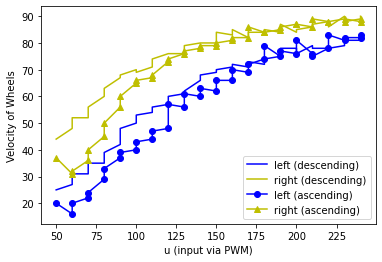

In [2]:
with open('data_coarse.txt', 'r') as file:
    data = np.array([[int(num) for num in line.strip().split(',')] for line in file.readlines()])

# compute velocity from distances
vleft  = data[:, 1]
vright = data[:, 2]


u = data[:, 0].reshape((-1, 1)) # duty cycle
left_des, left_asc = np.array_split(vleft, 2)

right_des, right_asc = np.array_split(vright, 2)

u_des, u_asc = np.array_split(u, 2)

plt.plot(u_des, left_des, 'b-',  u_des, right_des, 'y-')
plt.plot(u_asc, left_asc, 'b-o',  u_asc, right_asc, 'y-^')
plt.xlabel("u (input via PWM)")
plt.ylabel("Velocity of Wheels")
labels = ("left (descending)", "right (descending)",
          "left (ascending)" , "right (ascending)")
plt.legend(labels, loc=0)
plt.show()

### 3.3. Fine Data Collection

Now that we have a rough idea of our car's dynamics, we'll collect data appropriate for least-squares to find a linear approximation. In normal operation, the car only has to run within a small range of velocities, so we collect more samples over a smaller PWM range.

#### Tasks:
1. **Comment out code block `SID1` and uncomment `SID2`.**

2. **Set *LOW_PWM* and *HIGH_PWM*** corresponding to a roughly linear portion of the coarse data velocity graph from the previous step.
    - Aim for a range of about 50-60 PWM values (e.g. 140 to 190).
    - Our goal is that both wheels are able to acheive the same velocities for some two PWM input values in the range, so choose your range accordingly. 

3. Follow the steps above to run the program again. This time, after reading the data, copy it to **`data_fine.txt`**, instead of `data_coarse.txt`.

Then, we will perform least-squares regression on your data in the sections below.

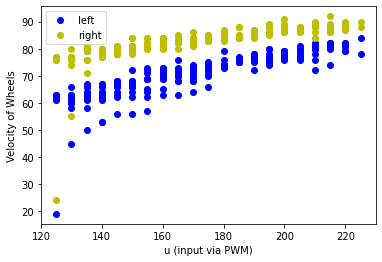

In [3]:
with open('data_fine.txt', 'r') as file:
    data = np.array([[int(num) for num in line.strip().split(',')] for line in file.readlines()])
    
# compute velocity from distances
vleft  = data[:, 1]
vright = data[:, 2]

u = data[:, 0].reshape((-1, 1)) # duty cycle

plt.plot(u, vleft, 'bo',  u, vright, 'yo')
plt.xlabel("u (input via PWM)")
plt.ylabel("Velocity of Wheels")
plt.legend(("left", "right"), loc=0)
plt.show()

### 3.4. Least-Squares Regression

Now, let's perform least-squares regression. Think about the least-squares problem we are solving, what equations we are using, and the variables we are solving.

#### Tasks:
1. Write a function that takes the data as parameters, performs least squares, and extracts the parameters. The functions [`np.hstack`](https://numpy.org/doc/stable/reference/generated/numpy.hstack.html), [`np.ones`](https://numpy.org/doc/stable/reference/generated/numpy.ones.html), [`np.shape`](https://numpy.org/doc/stable/reference/generated/numpy.shape.html), [`np.linalg.lstsq`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.lstsq.html) will be helpful here.
    - If you are having trouble figuring out how to setup the least-squares problem, check the lab note.
    
2. Call the function once for each wheel.

3. Record the values of $\theta$ and $\beta$ for each wheel.

In [4]:
# Write a function that formulates and performs least squares
# and returns theta and beta for one wheel
def identify_parameters(u, v):
    # Returns (theta, beta) for given (u, v)
    # YOUR CODE HERE 
    D = np.hstack((u, -1 * np.ones(np.shape(u))))
    s = v
    p = np.linalg.lstsq(D, s)
    # raise NotImplementedError() # REMOVE THIS LINE
    return p[0]

# extract parameters, call your function here
theta_left, beta_left = identify_parameters(u, vleft) # 0, 0
theta_right, beta_right = identify_parameters(u, vright) # 0, 0

print("float theta_left = {:.4g};".format(theta_left))
print("float theta_right = {:.4g};".format(theta_right))
print("float beta_left = {:.4g};".format(beta_left))
print("float beta_right = {:.4g};".format(beta_right))

float theta_left = 0.2436;
float theta_right = 0.1525;
float beta_left = -28.98;
float beta_right = -56.61;


/tmp/ipykernel_648/335647221.py:8: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  p = np.linalg.lstsq(D, s)


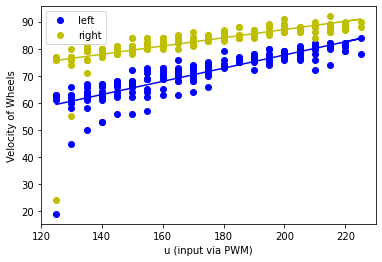

In [5]:
# plot results of least squares fit 
u = u.reshape(-1)
vleft_LS = theta_left*u-beta_left
vright_LS = theta_right*u-beta_right
plt.plot(u, vleft, 'bo',  u, vright, 'yo', u, vleft_LS, 'b-', u, vright_LS, 'y-')
plt.xlabel("u (input via PWM)")
plt.ylabel("Velocity of Wheels")
plt.legend(("left", "right"), loc=0)

### 3.5. Evaluate Your Fit

#### Tasks:
1. **Inspect the linearity of the plot.**
    - Make sure that the fitted lines have some y (velocity) values in common! This means both wheels can attain the same speed.
    - If they don't, the plot for the operating point in Part 4 will fail. You will need to recollect your fine data with a different, and likely wider, PWM range.
2. To test that we have estimated the parameters accurately, we will simulate the model using the parameters we have found. When we compare the simulated data with the collected data, we expect them to match up pretty well. Run the simulation below.

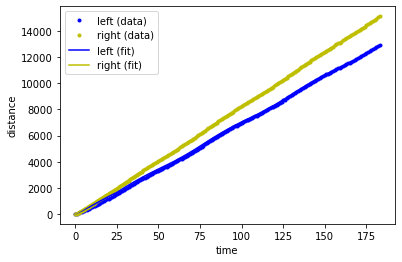

In [6]:
# model for simulation 
def sim(d0, u, theta, beta):
    d = np.zeros(len(u)+1)
    d[0] = d0
    for t in range(len(u)):
        d[t+1] = d[t] + theta*u[t] - beta
    return d
def get_distances_from_velocities(v):
    d = np.zeros(len(u) + 1)
    d[0] = 0
    for t in range(len(u)):
        d[t+1] = d[t] + v[t] 
    return d
        
# plot simulated trajectories 

dleft = get_distances_from_velocities(vleft)
dright = get_distances_from_velocities(vright)

dleft_simulated  = sim(0, u, theta_left, beta_left)
dright_simulated = sim(0, u, theta_right, beta_right)
plt.plot(dleft, 'b.', 
         dright, 'y.',
         dleft_simulated, 'b-', 
         dright_simulated, 'y-',
        )
plt.xlabel("time")
plt.ylabel("distance")
plt.legend(("left (data)", "right (data)", "left (fit)", "right (fit)"), loc='upper left')

<a id='part4'></a>
## <span style="color:navy">Part 4: Determining the Operating Point</span>
-----

In general, each wheel may have a different range of velocities, illustrated here.


<img src="./images/partial_overlap_lsq.png">


In order for the car to drive straight, the wheels must be moving at the same velocity. However, the motors (and hence the wheels) have different achievable velocity ranges, so we need to set the operating point to a velocity achievable by both wheels. A good choice of target velocity is the midpoint of the overlapping range of velocity. The below cell will calculate this. We will use this value in the next lab, along with the $\theta$ and $\beta$ values calculated earlier for both wheels.

Velocity range = [75.7, 83.8]

Operating point:
float v_star = 79.7;


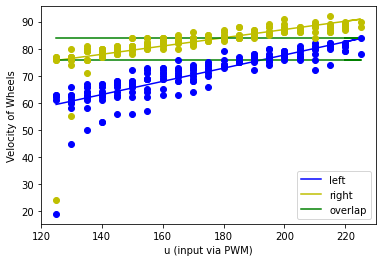

In [7]:
min_vel = max(min(vleft_LS), min(vright_LS))
max_vel = min(max(vleft_LS), max(vright_LS))

if ((min(vleft_LS) > max(vright_LS)) or (min(vright_LS) > max(vleft_LS))):
    print('Error: Velocity ranges of left and right wheels do not overlap. Recollect data_fine with a wider PWM range')
else:
    print('Velocity range = [{:0.1f}, {:0.1f}]'.format(min_vel, max_vel))
    midpoint = (min_vel+max_vel)/2
    print('\nOperating point:\nfloat v_star = {:.1f};'.format(midpoint))

    u = u.reshape(-1)
    vleft_LS = theta_left*u-beta_left
    vright_LS = theta_right*u-beta_right
    plt.plot(u, vleft_LS, 'b-', u, vright_LS, 'y-')
    for i in (min_vel, max_vel):
        plt.plot(u, 0*u + i, 'g-')
    plt.plot(u, vleft, 'bo',  u, vright, 'yo')
    plt.xlabel("u (input via PWM)")
    plt.ylabel("Velocity of Wheels")
    plt.legend(("left", "right", "overlap"), loc=0)


## <span style="color:#ba190f">CHECKOFF</span>
-----
### Checkoff Form (https://eecs16b.org/lab-checkoff)

- **Have all questions and plots completed in this notebook.**

- **Show your TA your data collection and parameters. Your TA will double check your parameters and graphs.**
    - Show your data collection and parameters (theta and beta values).
    - Show your operating point graph and that your wheels have overlapping velocities.

- **Be prepared to answer conceptual questions about the lab.**
 
- Think about the following questions for checkoff:
    - What is the difference between `data_coarse.txt` and `data_fine.txt`?
    - How did we come to finding theta and beta? What do they represent?
    - Why did we have to model each wheel seperately?
    - How could we use this model to make our car drive straight?

**After checkoff, please:**

- <span style="color:#ff0000"> **DO NOT DISMANTLE ANY CIRCUITS FROM YOUR PROJECT BREADBOARD! You will need them for the rest of the project!**</span>

- Store all your electrical components in a neat and organized manner.
- Make sure that all components that you received in your lab kit are stored safely for use in future labs.
- **Clean up your lab bench areas!** This includes turning off all lab equipment, putting all lab equipment probes back on the racks, returning all components you borrowed, putting the rest of the components back in your lab kits neatly, and throwing away any stripped wires.

- **Backup this lab notebook and all of the calculated parameters onto Google Drive/Git/etc. You will need these parameters for future labs, and you will need to write summaries for both the midterm and final lab reports!**


<a id='part4'></a>
# <span style="color:navy">Part 4: Final Lab Report Questions</span>
-----

The final lab report tests your understanding of EECS 16B Labs 6-9, with an emphasis on conceptual and
analytical understanding. It also allows you to look at these labs from a bigger picture and reflect on your design
process and choices. All of the final lab report questions have been compiled together [here](https://edstem.org/us/courses/34924/discussion/2428391). The entire final lab report will be due on **Friday, 05/05**.

## Questions

**Summary**

- Give a summary in your own words of what you did in this lab.

**1. What do $\theta$ and $\beta$ represent physically, not mathematically? What are your values of $\theta$ and $\beta$, and do they reflect the car's performance while collecting data? Why/why not?**

**2. How did you choose the PWM input range for fine data collection? If there were other data ranges that could have also conceivably been chosen, why did you choose this range over other ranges? Please include a graph of your car's coarse data to support your answers.**

**3. To implement a higher order polynomial model, what would you need to change in the current lab flow to calculate the coefficients for this new model? Evaluate the benefits and drawbacks between using a higher order model vs. a linear model.**

**4. As the batteries run low, assume that the corresponding velocities for each PWM input go down linearly. In other words, the velocity vs. PWM input curves for both wheels shift down by some value $v_o$, where $v_o$ is non-negative and increases as the battery power gets lower. If we still aim for the same operating point velocity and use the same linear model, how will the car's performance change as the battery level decreases?**